C:\Users\Moe\AppData\Local\Temp\ipykernel_27864\1416768258.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coef.values, y=top_coef.index, palette="coolwarm")


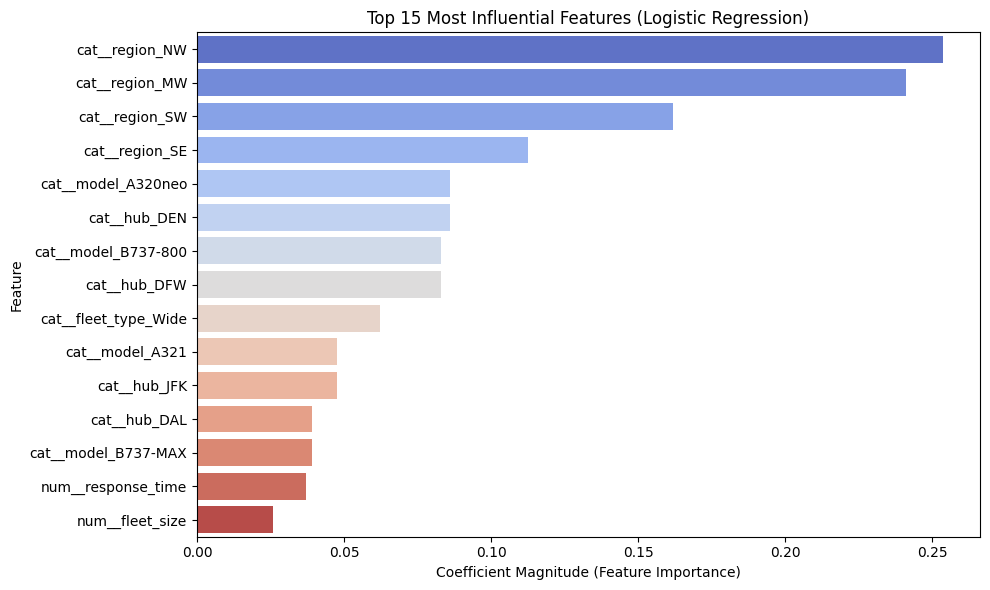

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3

# Load data
conn = sqlite3.connect("../data/aircomm_insight.db")
query = """
SELECT 
    l.region,
    l.signal_strength,
    l.response_time,
    e.model,
    e.fleet_type,
    e.hub,
    e.fleet_size,
    CASE WHEN l.error_code != 0 THEN 1 ELSE 0 END AS error_flag
FROM aircraft_logs l
JOIN aircraft_metadata_enriched e ON l.aircraft_id = e.aircraft_id
"""
df = pd.read_sql(query, conn)
conn.close()

# Prepare features and target
X = df.drop("error_flag", axis=1)
y = df["error_flag"]

categorical = ["region", "model", "fleet_type", "hub"]
numerical = ["signal_strength", "response_time", "fleet_size"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(drop="first"), categorical)
])

# Fit-transform for direct access
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Fit Logistic Regression
lr = LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42, stratify=y)
lr.fit(X_train, y_train)

# Coefficients = feature importance (use absolute value for magnitude)
coef = pd.Series(lr.coef_[0], index=feature_names)
top_coef = coef.abs().sort_values(ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_coef.values, y=top_coef.index, palette="coolwarm")
plt.title("Top 15 Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient Magnitude (Feature Importance)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Print classification report
# Make predictions
y_pred_lr = lr.predict(X_test)
print("Classification Report for Logistic Regression:\n")
print(classification_report(y_test, y_pred_lr))


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.36      0.04      0.07       331
           1       0.55      0.95      0.70       419

    accuracy                           0.55       750
   macro avg       0.46      0.49      0.38       750
weighted avg       0.47      0.55      0.42       750



<Figure size 600x500 with 0 Axes>

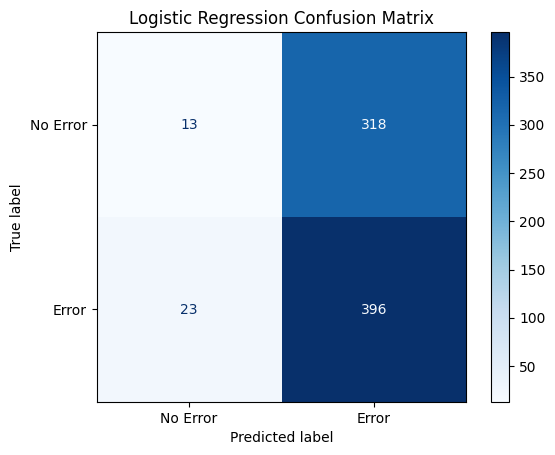

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Error", "Error"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


### 📊 Classification Report – Logistic Regression (Aircraft Error Prediction)


---

### 🧠 Interpretation

#### 🔹 Class 0 – "No Error"
- **Precision (0.36):** When the model predicted no error, it was correct 36% of the time.
- **Recall (0.04):** It only identified 4% of the actual no-error flights — indicating **many false positives**.

#### 🔹 Class 1 – "Error"
- **Precision (0.55):** When predicting an error, it was correct 55% of the time.
- **Recall (0.95):** It correctly flagged 95% of real error cases — **very strong recall** for failure detection.

#### 🎯 Overall Accuracy: **55%**
- This model performs slightly better than chance, but heavily **biased toward catching errors**.
- Likely due to **class imbalance** or model overfitting.

---

### ✅ Summary

> “This model prioritizes recall for error cases — valuable for a safety-critical system like aircraft communications. However, it struggles to identify clean flights, which may cause operational noise or alert fatigue. I would improve this with class balancing or an XGBoost model tuned for precision-recall tradeoffs.”